In [11]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
keras.__version__

'2.10.0'

In [13]:
tensorflow.__version__

'2.10.0'

In [14]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

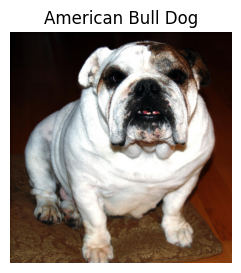

In [15]:
img = load_img('images/2906008778_1baeac7c1b_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Bull Dog')
plt.show()

In [16]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_37830/327069532.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i)


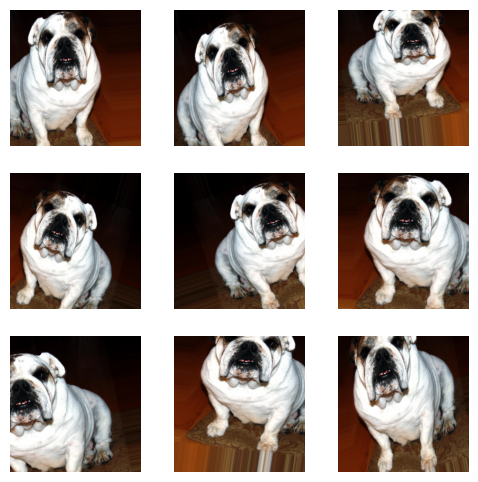

In [17]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

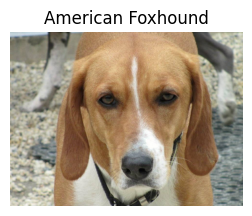

In [18]:
img = load_img('images/8666079478_f15a4bf761_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Foxhound')
plt.show()

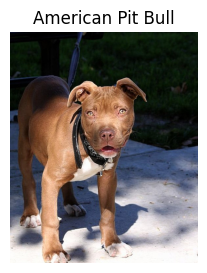

In [19]:
img = load_img('images/3253955567_0a760d07f4.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Pit Bull')
plt.show()

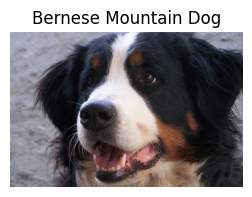

In [20]:
img = load_img('images/515115458_3a2d8e63b0_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Bernese Mountain Dog')
plt.show()

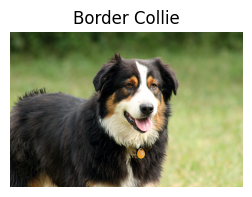

In [21]:
img = load_img('images/367223817_8b489117ba.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Border Collie')
plt.show()

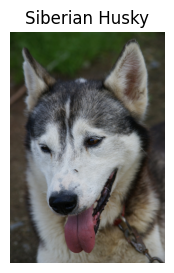

In [22]:
img = load_img('images/1359977110_457925e5f6_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Siberian Husky')
plt.show()

In [23]:
# default settings
img_width, img_height = 224, 224

train_dir = 'data/dogs/train'
validate_dir = 'data/dogs/validate'
nb_epochs = 20
batch_size = 64
nb_classes = len(glob.glob(train_dir + '/*'))

In [24]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

386


In [25]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

110


In [26]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [27]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [28]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 386 images belonging to 6 classes.


In [29]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 110 images belonging to 6 classes.


In [30]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
resnet101_model = ResNet101(weights = 'imagenet', include_top = False)
x = resnet101_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs = resnet101_model.input, outputs = predictions)

Metal device set to: Apple M1


2022-10-18 03:02:06.747859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 03:02:06.748492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


171446536/171446536 [==============================] - 4s 0us/step


In [31]:
# freeze all layers of the pre-trained model
for layer in resnet101_model.layers:
    layer.trainable = False

In [32]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [33]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
#     samples_per_epoch = nb_train_samples,
    validation_data = validate_generator
#     nb_val_samples = nb_validate_samples,
#     class_weight='auto')
)
print('Training time: %s' % (now() - t))

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_37830/1653497777.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


Epoch 1/20


2022-10-18 03:02:19.350343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 03:02:24.665156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.2022 - accuracy: 0.1606

2022-10-18 03:02:55.904305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 47s 5s/step - loss: 3.2022 - accuracy: 0.1606 - val_loss: 4.2183 - val_accuracy: 0.1636
Epoch 2/20
7/7 [==============================] - 29s 4s/step - loss: 2.3783 - accuracy: 0.1606 - val_loss: 1.8288 - val_accuracy: 0.1545
Epoch 3/20
7/7 [==============================] - 22s 3s/step - loss: 2.0300 - accuracy: 0.1658 - val_loss: 1.8115 - val_accuracy: 0.1909
Epoch 4/20
7/7 [==============================] - 21s 3s/step - loss: 1.9524 - accuracy: 0.1632 - val_loss: 1.7748 - val_accuracy: 0.1818
Epoch 5/20
7/7 [==============================] - 21s 3s/step - loss: 2.2076 - accuracy: 0.1528 - val_loss: 1.7737 - val_accuracy: 0.2273
Epoch 6/20
7/7 [==============================] - 22s 3s/step - loss: 2.1169 - accuracy: 0.1710 - val_loss: 1.7585 - val_accuracy: 0.2273
Epoch 7/20
7/7 [==============================] - 20s 3s/step - loss: 1.9489 - accuracy: 0.1710 - val_loss: 1.7931 - val_accuracy: 0.2000
Epoch 8/20
7/7 [=============================

In [34]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_37830/2432328286.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)


Test Score: 1.7426724433898926
Test Accuracy: 0.27272728085517883


In [35]:
# save transfer learning model for offline prediction purposes
model.save('dogs_resnet101_model_tl.h5')

In [36]:
# xfer_acc = transfer_learning_history.history['accuracy']
# val_acc = transfer_learning_history.history['val_accuracy']
# xfer_loss = transfer_learning_history.history['loss']
# val_loss = transfer_learning_history.history['val_loss']
# epochs = range(len(xfer_acc))

# x = np.array(epochs)
# y = np.array(xfer_acc)
# x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y)
# plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

# x1 = np.array(epochs)
# y1 = np.array(val_acc)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

# plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
# plt.title('Transfer Learning - Training and Validation Accuracy')
# plt.legend(loc = 'lower left', fontsize = 9)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.ylim(0,1.05)

# plt.figure()
# x = np.array(epochs)
# y = np.array(xfer_loss)
# x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y, x_smooth)
# plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

# x1 = np.array(epochs)
# y1 = np.array(val_loss)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

# plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
# plt.title('Transfer Learning - Training and Validation Loss')
# plt.legend(loc = 'upper right', fontsize = 9)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim(0, 3)
# plt.show()

In [37]:
validate_generator.total_batches_seen

44

In [38]:
num_images = len(glob.glob("data/dogs/dogs_test/*.jpg"))

In [39]:
predict_files = glob.glob("data/dogs/dogs_test/*.jpg")

In [40]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [41]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

2022-10-18 03:09:42.736294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 36ms/step


In [42]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,3
1,data/dogs/dogs_test/border_collie_5436726107_0...,2
2,data/dogs/dogs_test/siberian_husky_5054137283_...,2
3,data/dogs/dogs_test/american_foxhound_14768856...,3
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,3
5,data/dogs/dogs_test/american_pit_bull_27048365...,2
6,data/dogs/dogs_test/american_pit_bull_24000237...,0
7,data/dogs/dogs_test/american_foxhound_16969245...,3
8,data/dogs/dogs_test/american_bull_dog_42927468...,2
9,data/dogs/dogs_test/siberian_husky_8460153366_...,3


In [43]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [44]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,bernese_mountain_dog
1,data/dogs/dogs_test/border_collie_5436726107_0...,american_pit_bull
2,data/dogs/dogs_test/siberian_husky_5054137283_...,american_pit_bull
3,data/dogs/dogs_test/american_foxhound_14768856...,bernese_mountain_dog
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,bernese_mountain_dog
5,data/dogs/dogs_test/american_pit_bull_27048365...,american_pit_bull
6,data/dogs/dogs_test/american_pit_bull_24000237...,american_bull_dog
7,data/dogs/dogs_test/american_foxhound_16969245...,bernese_mountain_dog
8,data/dogs/dogs_test/american_bull_dog_42927468...,american_pit_bull
9,data/dogs/dogs_test/siberian_husky_8460153366_...,bernese_mountain_dog


In [45]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

In [47]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG16 model - train all layers
for layer in model.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    validation_data = validate_generator)
print('Training time: %s' % (now() - t))

/Users/Janeshelbyporter/miniforge3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_37830/708344884.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fine_tuning_history = model.fit_generator(


Epoch 1/20


2022-10-18 03:10:01.050245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.5131 - accuracy: 0.1762

2022-10-18 03:11:05.652889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 77s 8s/step - loss: 3.5131 - accuracy: 0.1762 - val_loss: 1.7658 - val_accuracy: 0.2182
Epoch 2/20
7/7 [==============================] - 47s 6s/step - loss: 2.9853 - accuracy: 0.2098 - val_loss: 1.7826 - val_accuracy: 0.1727
Epoch 3/20
7/7 [==============================] - 37s 5s/step - loss: 2.5241 - accuracy: 0.2073 - val_loss: 1.7715 - val_accuracy: 0.2182
Epoch 4/20
7/7 [==============================] - 45s 6s/step - loss: 2.1075 - accuracy: 0.2358 - val_loss: 1.7851 - val_accuracy: 0.1636
Epoch 5/20
7/7 [==============================] - 42s 6s/step - loss: 1.9276 - accuracy: 0.2902 - val_loss: 1.9278 - val_accuracy: 0.1545
Epoch 6/20
7/7 [==============================] - 33s 5s/step - loss: 1.7393 - accuracy: 0.2979 - val_loss: 2.0434 - val_accuracy: 0.1545
Epoch 7/20
7/7 [==============================] - 44s 5s/step - loss: 1.6523 - accuracy: 0.3264 - val_loss: 1.9779 - val_accuracy: 0.1545
Epoch 8/20
7/7 [=============================

In [48]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_37830/2432328286.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)


Test Score: 4.9644856452941895
Test Accuracy: 0.15454547107219696


In [49]:
# save fine-tuning model for offline prediction purposes
model.save('dogs_resnet101_model_ft.h5')

In [50]:
# ft_acc = fine_tuning_history.history['accuracy']
# val_acc = fine_tuning_history.history['val_accuracy']
# ft_loss = fine_tuning_history.history['loss']
# val_loss = fine_tuning_history.history['val_loss']
# epochs = range(len(ft_acc))

# x = np.array(epochs)
# y = np.array(xfer_acc)
# x_smooth = np.linspace(x.min(), x.max(), 300)
# y_smooth = make_interp_spline(x, y, x_smooth)
# plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

# x1 = np.array(epochs)
# y1 = np.array(val_acc)
# x1_smooth = np.linspace(x1.min(), x1.max(), 300)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

# plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
# plt.title('Fine-Tuning - Training and Validation Accuracy')
# plt.legend(loc = 'lower left', fontsize = 9)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.ylim(0,1.02)

# plt.figure()
# x = np.array(epochs)
# y = np.array(xfer_loss)
# x_smooth = np.linspace(x.min(), x.max(), 300)
# y_smooth = make_interp_spline(x, y, x_smooth)
# plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

# x1 = np.array(epochs)
# y1 = np.array(val_loss)
# x1_smooth = np.linspace(x1.min(), x1.max(), 300)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

# plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
# plt.title('Fine-Tuning - Training and Validation Loss')
# plt.legend(loc = 'upper right', fontsize = 9)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim(0, 3)
# plt.show()

In [51]:
validate_generator.total_batches_seen

88

In [52]:
# predict unseen images
predict_files = glob.glob("data/dogs/dogs_test/*.jpg")

In [53]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [54]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

2022-10-18 03:26:48.029672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 47ms/step


In [55]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor 
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,3
1,data/dogs/dogs_test/border_collie_5436726107_0...,4
2,data/dogs/dogs_test/siberian_husky_5054137283_...,3
3,data/dogs/dogs_test/american_foxhound_14768856...,3
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,3
5,data/dogs/dogs_test/american_pit_bull_27048365...,3
6,data/dogs/dogs_test/american_pit_bull_24000237...,3
7,data/dogs/dogs_test/american_foxhound_16969245...,3
8,data/dogs/dogs_test/american_bull_dog_42927468...,3
9,data/dogs/dogs_test/siberian_husky_8460153366_...,3


In [56]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [57]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,bernese_mountain_dog
1,data/dogs/dogs_test/border_collie_5436726107_0...,border_collie
2,data/dogs/dogs_test/siberian_husky_5054137283_...,bernese_mountain_dog
3,data/dogs/dogs_test/american_foxhound_14768856...,bernese_mountain_dog
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,bernese_mountain_dog
5,data/dogs/dogs_test/american_pit_bull_27048365...,bernese_mountain_dog
6,data/dogs/dogs_test/american_pit_bull_24000237...,bernese_mountain_dog
7,data/dogs/dogs_test/american_foxhound_16969245...,bernese_mountain_dog
8,data/dogs/dogs_test/american_bull_dog_42927468...,bernese_mountain_dog
9,data/dogs/dogs_test/siberian_husky_8460153366_...,bernese_mountain_dog
